# Run the classifier

This notebook uses functions from [classifier.py](classifier.py) in order to run the classifier.

In [1]:
import pandas as pd
import numpy as np

import classifier

2025-02-11 18:26:50.554988: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
SEQ_LEN=180
SPLIT=(0.6, 0.2, 0.2)

## Load data

Read data from the directory that contains our preprocessed data. We still have some preprocessing to do though, because the length of input sequences is a variable that we want to be able to fiddle with.

In [3]:
data_path = 'dataset/displacements/'

inputs_by_player = classifier.players_inputs(data_path)

inputs_by_player['aklo'].shape

(128676, 3)

In [4]:
inputs_by_player.keys()

dict_keys(['2saint', 'aklo', 'amsa', 'axe', 'cody', 'hbox', 'kodorin', 'logan', 'mang0', 'moky', 'n0ne', 'plup', 'sfat', 'wizzrobe', 'yingling', 'zain'])

## Organize data into sequences and split data into training, validation, and test sets

In [6]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = classifier.prepare_data(inputs_by_player, SEQ_LEN, SPLIT)

## Create the model

Here is the constructor code for the best version of the model that I tested. Some of the variables that I tested are now hardcoded in the current version, and so the code that is actually in [classifier.py](classifier.py) is not guaranteed to be the same.

```python
def createClassifier(width=3, seq_len=180):
    """
    Returns a classifier model with the given input shape. Default to width of 3, sequence length of 180.
    """
    input_layer = Input(shape=(seq_len, width))
    conv1 = Conv1D(filters=32, kernel_size=7, strides=2, activation=ELU())(input_layer)
    conv2 = Conv1D(filters=32, kernel_size=3, strides=1, activation=ELU())(input_layer)

    catted = Concatenate(axis=1)([conv1, conv2])
    elu1 = ELU(32)(catted)
    conv3 = Conv1D(filters=32, kernel_size=2, strides=1, activation=ELU())(elu1)
    conv4 = Conv1D(filters=32, kernel_size=2, strides=1, activation=ELU())(conv3)
    drop1 = Dropout(0.2)(conv4)

    gru1 = LSTM(32, return_sequences=True)(drop1)
    gru2 = LSTM(32)(gru1)
    drop2 = Dropout(0.2)(gru2)

    output = Dense(len(players_set), activation='softmax')(drop2)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
```

In [7]:
model = classifier.createClassifier(width=3, seq_len=SEQ_LEN)

2025-02-11 18:35:35.294200: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-02-11 18:35:35.452971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 18:35:35.453675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 18:35:35.4

## Train the model

We now fit the model to the data that we prepared earlier. It is also possible to load in weights instead of running this, so if you already have appropriate weights, this step is optionsl

In [8]:
# You do not need to run this if you already have model weights saved somewhere
history = model.fit(
    train_x, train_y, epochs=60, verbose=1, batch_size=64, validation_data=(valid_x, valid_y)
)

Epoch 1/60


2025-02-11 18:35:35.805028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 18:35:35.806082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 18:35:35.806833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190/190 [==============================] - ETA: 0s - loss: 2.6384 - accuracy: 0.1503

2025-02-11 18:36:37.543340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 18:36:37.544337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 18:36:37.545127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190/190 [==============================] - 67s 337ms/step - loss: 2.6384 - accuracy: 0.1503 - val_loss: 2.5547 - val_accuracy: 0.1828
Epoch 2/60
190/190 [==============================] - 60s 314ms/step - loss: 2.4544 - accuracy: 0.2134 - val_loss: 2.2900 - val_accuracy: 0.2787
Epoch 3/60
190/190 [==============================] - 64s 337ms/step - loss: 2.3186 - accuracy: 0.2541 - val_loss: 2.2756 - val_accuracy: 0.2631
Epoch 4/60
190/190 [==============================] - 64s 336ms/step - loss: 2.1483 - accuracy: 0.2935 - val_loss: 2.0471 - val_accuracy: 0.3193
Epoch 5/60
190/190 [==============================] - 62s 328ms/step - loss: 2.0636 - accuracy: 0.3105 - val_loss: 1.9124 - val_accuracy: 0.3545
Epoch 6/60
190/190 [==============================] - 67s 352ms/step - loss: 1.9755 - accuracy: 0.3333 - val_loss: 1.9833 - val_accuracy: 0.3423
Epoch 7/60
190/190 [==============================] - 66s 346ms/step - loss: 1.8162 - accuracy: 0.3822 - val_loss: 1.6786 - val_accuracy: 0.4

In [9]:
# OPTIONAL: run something like this instead of training if you have saved weights previously
# model.load_weights('models/default')

## Plot learning curve

In [10]:
import matplotlib.pyplot as plt

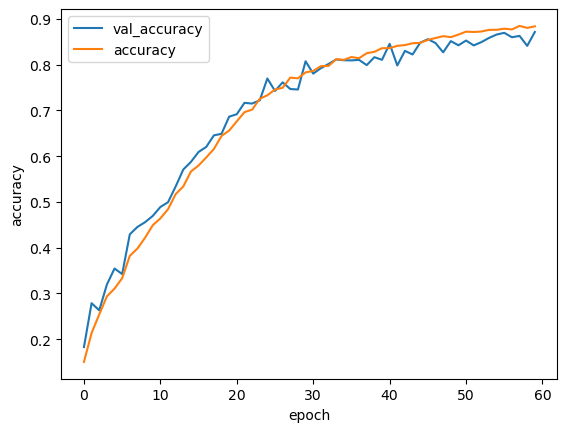

In [11]:
plt.plot('val_accuracy', data=history.history)
plt.plot('accuracy', data=history.history)
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()

# plt.savefig('results/learning_curve')
plt.show()

## Example prediction



In [12]:
example_df = pd.read_csv('dataset/displacements/2saint_aklo_18-07-21_13:21.csv', index_col=None)
predict = model(np.array([example_df.iloc[range(SEQ_LEN), :]], dtype=np.float32), training=False)

classifier.i_to_p[np.argmax(predict)]

'2saint'

In [13]:
np.argmax(predict)

0

In [14]:
# FIXME
# It would be best to use model store/load rather than checkpoints
# https://www.tensorflow.org/guide/keras/serialization_and_saving
# model.save_weights('models/test')

## Test the model

Run the model on the test data and record performance metrics, namely, top N accuracy. More detailed testing can be found in [test_model.ipynb](test_model.ipynb)

### Get test outputs

In [15]:
test_h = []
test_h = model.predict(test_x)

test_h.shape

2025-02-11 19:38:00.882378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-02-11 19:38:00.883391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-02-11 19:38:00.884163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

127/127 [==============================] - 7s 51ms/step


(4037, 16)

### Compare test outputs to labels

In [17]:
ranks = []

for i in range(test_h.shape[0]):
    rankings = np.argsort(test_h[i])
    rank = (len(classifier.players_set)-1) - np.where((rankings == np.argmax(test_y[i])))[0][0]
    ranks.append(rank)

topn_occurences = []
running = 0
for i in range(len(classifier.players_set)):
    topn_occurences.append(ranks.count(i) + running)
    running += ranks.count(i)

topn_acc = [t / topn_occurences[-1] for t in topn_occurences]

print(topn_acc)

[0.8674758484022789, 0.9534307654198663, 0.977953926182809, 0.989100817438692, 0.9935595739410453, 0.9965320782759475, 0.9975229130542482, 0.9990091652216992, 0.9992568739162745, 0.9995045826108496, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
